In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler,LabelEncoder
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

import warnings
warnings.filterwarnings('ignore')

In [2]:
metadata = pd.read_excel("dataset.xls")
metadata.head()

,Age (4 levels),Gender,French nationality,Field of study,Year of university,Learning disabilities,Difficulty memorizing lessons,Professional objective,Informed about opportunities,Satisfied with living conditions,...,Anxiety symptoms,Panic attack symptoms,Depressive symptoms,Cigarette smoker (5 levels),Cigarette smoker (3 levels),Drinker (3 levels),Drinker (2 levels),Binge drinking,Marijuana use,Other recreational drugs
0,20 and more,female,yes,humanities,second,no,no,yes,yes,yes,...,no,no,no,no,no,no,no or occasionally,no,no,no
1,19,female,yes,humanities,second,no,no,yes,yes,yes,...,no,no,no,regularly,occasionally to regularly,occasionally,no or occasionally,no,no,no
2,20 and more,female,yes,humanities,second,no,no,yes,yes,yes,...,no,no,yes,no,no,occasionally,no or occasionally,no,no,no
3,19,female,yes,humanities,second,no,no,yes,yes,yes,...,no,no,no,no,no,occasionally,no or occasionally,no,no,no
4,18,female,yes,humanities,second,no,no,yes,yes,yes,...,no,no,no,no,no,no,no or occasionally,no,no,no


# Preprocessing

In [3]:
feat_columns = metadata.columns[metadata.notna().all()].tolist()
selected_features = metadata[feat_columns]

# select all parameters with missing data
missing_data_columns = metadata.columns[metadata.isna().any()].tolist()
missing_data = metadata[missing_data_columns]

In [4]:
'''
Create new DataFrame named "dummy_feat" by applying one-hot encoding to the 'Depressive symptoms' and 'Anxiety symptoms'
columns of the 'selected' DataFrame using the "pd.get_dummies()" function. This creates new columns for each unique value
in the original columns.
'''
dummy_feat = pd.get_dummies(selected_features[['Depressive symptoms','Anxiety symptoms']])
selected_features = selected_features.join(dummy_feat)
selected_features.drop(labels=['Depressive symptoms','Anxiety symptoms'], axis=1, inplace=True)
dummy_feat.head()

,Depressive symptoms_no,Depressive symptoms_yes,Anxiety symptoms_no,Anxiety symptoms_yes
0,1,0,1,0
1,1,0,1,0
2,0,1,1,0
3,1,0,1,0
4,1,0,1,0


In [5]:
'''
Parameters with object values are filtered to replace their string
values with numeric equalent through Label encoder.
Dictionary named "dummy_encoder" stores instances of the LabelEncoder class for each object type column
in a DataFrame named "selected".
For each object column, the code initializes a LabelEncoder object named "le", and then applies the fit_transform
method to the column after converting it to a string data type using the "astype" method. This encodes each
unique value in the column as a numerical label, which can be used as input to machine learning models.

The encoded values are stored in the same column in "selected". Finally, the LabelEncoder instance is added to
the "dummy_encoder" dictionary using the column name as the key. This allows for easy reference to the LabelEncoder
instances later on, if needed.
'''

# for features
features_obj_columns = list(selected_features.select_dtypes(include='object').columns)
features_encoder = {}
for col in features_obj_columns:
    le = LabelEncoder()
    selected_features.loc[:,col] = le.fit_transform(selected_features[col].astype(str))
    features_encoder[col] = le
    
# for missing data
# because label encoder will encode even nan value, so to preserve it
# first we filter out nan data, then we train encoder by skipping nan rows, 
# then create copy of that column and transform str data by skipping nan rows
missing_obj_columns = list(missing_data.select_dtypes(include='object').columns)
missing_encoder = {}
for col in missing_obj_columns:
    le = LabelEncoder()
    nan_mask = missing_data[col].isna()
    le.fit_transform(missing_data[col][~nan_mask])
    col_copy = missing_data[col].copy()
    col_copy.loc[~nan_mask] = le.transform(missing_data[col][~nan_mask])
    missing_data.loc[:,col] = col_copy.astype('float64')
    missing_encoder[col] = le

In [6]:
selected_features.head()

,Age (4 levels),Gender,French nationality,Field of study,Year of university,Learning disabilities,Difficulty memorizing lessons,Professional objective,Informed about opportunities,Living with a partner/child,...,Urinalysis leukocyturia),Urinalysis (positive nitrite test),Abnormal urinalysis,Control examination needed,Panic attack symptoms,Binge drinking,Depressive symptoms_no,Depressive symptoms_yes,Anxiety symptoms_no,Anxiety symptoms_yes
0,2,0,1,0,1,0,0,1,1,0,...,1,0,1,1,0,0,1,0,1,0
1,1,0,1,0,1,0,0,1,1,0,...,1,0,1,0,0,0,1,0,1,0
2,2,0,1,0,1,0,0,1,1,0,...,0,0,0,0,0,0,0,1,1,0
3,1,0,1,0,1,0,0,1,1,0,...,1,0,1,0,0,0,1,0,1,0
4,0,0,1,0,1,0,0,1,1,0,...,0,0,1,0,0,0,1,0,1,0


In [7]:
missing_data.head()

,Satisfied with living conditions,Parental home,Having only one parent,Long commute,Mode of transportation,Private health insurance,Weight (kg),Height (cm),Overweight and obesity,Systolic blood pressure (mmHg),...,Prehypertension or hypertension,Heart rate (bpm),Abnormal heart rate,Vaccination up to date,Cigarette smoker (5 levels),Cigarette smoker (3 levels),Drinker (3 levels),Drinker (2 levels),Marijuana use,Other recreational drugs
0,1.0,0.0,0.0,0.0,2.0,0.0,62.0,165.0,0.0,NaN,...,NaN,75.0,0.0,NaN,2.0,1.0,0.0,0.0,0.0,0.0
1,1.0,1.0,0.0,1.0,1.0,1.0,57.0,170.0,0.0,10.0,...,0.0,65.0,0.0,NaN,4.0,2.0,1.0,0.0,0.0,0.0
2,1.0,0.0,1.0,0.0,0.0,1.0,NaN,162.0,NaN,11.0,...,0.0,65.0,0.0,NaN,2.0,1.0,1.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,2.0,1.0,85.0,193.0,0.0,11.0,...,0.0,70.0,0.0,NaN,2.0,1.0,1.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,2.0,1.0,41.0,161.0,0.0,10.0,...,0.0,NaN,NaN,1.0,2.0,1.0,0.0,0.0,0.0,0.0


In [8]:
# create new instance of feature(dummy df) with target containing missing data
# because we have 21 targets, so creating 21 impute data arrays
living_conditions = np.append(selected_features.values, missing_data['Satisfied with living conditions'].values.reshape(-1,1), axis=1)
parental_data = np.append(selected_features.values, missing_data['Parental home'].values.reshape(-1,1), axis=1)
pet_data = np.append(selected_features.values, missing_data['Having only one parent'].values.reshape(-1,1), axis=1)
commute_data = np.append(selected_features.values, missing_data['Long commute'].values.reshape(-1,1), axis=1)
transportation_data = np.append(selected_features.values, missing_data['Mode of transportation'].values.reshape(-1,1), axis=1)
insurance_data = np.append(selected_features.values, missing_data['Private health insurance '].values.reshape(-1,1), axis=1)
weight_data = np.append(selected_features.values, missing_data['Weight (kg)'].values.reshape(-1,1), axis=1)
height_data = np.append(selected_features.values, missing_data['Height (cm)'].values.reshape(-1,1), axis=1)
obesity_data = np.append(selected_features.values, missing_data['Overweight and obesity'].values.reshape(-1,1), axis=1)
systolic_data = np.append(selected_features.values, missing_data['Systolic blood pressure (mmHg)'].values.reshape(-1,1), axis=1)
diastolic_data = np.append(selected_features.values, missing_data['Diastolic blood pressure (mmHg)'].values.reshape(-1,1), axis=1)
hypertension_data = np.append(selected_features.values, missing_data['Prehypertension or hypertension'].values.reshape(-1,1), axis=1)
heartrate_data = np.append(selected_features.values, missing_data['Heart rate (bpm)'].values.reshape(-1,1), axis=1)
abnormal_hr_data = np.append(selected_features.values, missing_data['Abnormal heart rate'].values.reshape(-1,1), axis=1)
vaccination_data = np.append(selected_features.values, missing_data['Vaccination up to date'].values.reshape(-1,1), axis=1)
smoke_lvl5_data = np.append(selected_features.values, missing_data['Cigarette smoker (5 levels)'].values.reshape(-1,1), axis=1)
smoke_lvl3_data = np.append(selected_features.values, missing_data['Cigarette smoker (3 levels)'].values.reshape(-1,1), axis=1)
drinker_lvl3_data = np.append(selected_features.values, missing_data['Drinker (3 levels)'].values.reshape(-1,1), axis=1)
drinker_lvl2_data = np.append(selected_features.values, missing_data['Drinker (2 levels)'].values.reshape(-1,1), axis=1)
marijuana_data = np.append(selected_features.values, missing_data['Marijuana use'].values.reshape(-1,1), axis=1)
drugs_data = np.append(selected_features.values, missing_data['Other recreational drugs'].values.reshape(-1,1), axis=1)

# MICE

In [9]:
from impyute.imputation.cs import mice

In [10]:
# mice imputing data
mice_imputed = mice(missing_data.values)
missing_data = pd.DataFrame(mice_imputed, columns=missing_data.columns)

In [11]:
missing_data.head(5)

,Satisfied with living conditions,Parental home,Having only one parent,Long commute,Mode of transportation,Private health insurance,Weight (kg),Height (cm),Overweight and obesity,Systolic blood pressure (mmHg),...,Prehypertension or hypertension,Heart rate (bpm),Abnormal heart rate,Vaccination up to date,Cigarette smoker (5 levels),Cigarette smoker (3 levels),Drinker (3 levels),Drinker (2 levels),Marijuana use,Other recreational drugs
0,1.0,0.0,0.0,0.0,2.0,0.0,62.000000,165.0,0.000000,10.717904,...,-0.020205,75.00000,0.000000,0.686376,2.0,1.0,0.0,0.0,0.0,0.0
1,1.0,1.0,0.0,1.0,1.0,1.0,57.000000,170.0,0.000000,10.000000,...,0.000000,65.00000,0.000000,0.817120,4.0,2.0,1.0,0.0,0.0,0.0
2,1.0,0.0,1.0,0.0,0.0,1.0,58.018827,162.0,0.189783,11.000000,...,0.000000,65.00000,0.000000,0.921888,2.0,1.0,1.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,2.0,1.0,85.000000,193.0,0.000000,11.000000,...,0.000000,70.00000,0.000000,0.874169,2.0,1.0,1.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,2.0,1.0,41.000000,161.0,0.000000,10.000000,...,0.000000,75.43032,0.017448,1.000000,2.0,1.0,0.0,0.0,0.0,0.0


In [12]:
# round values for int based parameters
missing_data.loc[:,'Satisfied with living conditions'] = missing_data.loc[:,'Satisfied with living conditions'].round().astype('int')
missing_data.loc[:,'Parental home'] = missing_data.loc[:,'Parental home'].round().astype('int')
missing_data.loc[:,'Having only one parent'] = missing_data.loc[:,'Having only one parent'].round().astype('int')
missing_data.loc[:,'Long commute'] = missing_data.loc[:,'Long commute'].round().astype('int')
missing_data.loc[:,'Mode of transportation'] = missing_data.loc[:,'Mode of transportation'].round().astype('int')
missing_data.loc[:,'Private health insurance '] = missing_data.loc[:,'Private health insurance '].round().astype('int')
missing_data.loc[:,'Overweight and obesity'] = missing_data.loc[:,'Overweight and obesity'].round().astype('int')
missing_data.loc[:,'Prehypertension or hypertension'] = missing_data.loc[:,'Prehypertension or hypertension'].round().astype('int')
missing_data.loc[:,'Abnormal heart rate'] = missing_data.loc[:,'Abnormal heart rate'].round().astype('int')
missing_data.loc[:,'Vaccination up to date'] = missing_data.loc[:,'Vaccination up to date'].round().astype('int')
missing_data.loc[:,'Cigarette smoker (5 levels)'] = missing_data.loc[:,'Cigarette smoker (5 levels)'].round().astype('int')
missing_data.loc[:,'Cigarette smoker (3 levels)'] = missing_data.loc[:,'Cigarette smoker (3 levels)'].round().astype('int')
missing_data.loc[:,'Drinker (3 levels)'] = missing_data.loc[:,'Drinker (3 levels)'].round().astype('int')
missing_data.loc[:,'Drinker (2 levels)'] = missing_data.loc[:,'Drinker (2 levels)'].round().astype('int')
missing_data.loc[:,'Marijuana use'] = missing_data.loc[:,'Marijuana use'].round().astype('int')
missing_data.loc[:,'Other recreational drugs'] = missing_data.loc[:,'Other recreational drugs'].round().astype('int')
missing_data.head(5)

,Satisfied with living conditions,Parental home,Having only one parent,Long commute,Mode of transportation,Private health insurance,Weight (kg),Height (cm),Overweight and obesity,Systolic blood pressure (mmHg),...,Prehypertension or hypertension,Heart rate (bpm),Abnormal heart rate,Vaccination up to date,Cigarette smoker (5 levels),Cigarette smoker (3 levels),Drinker (3 levels),Drinker (2 levels),Marijuana use,Other recreational drugs
0,1,0,0,0,2,0,62.000000,165.0,0,10.717904,...,0,75.00000,0,1,2,1,0,0,0,0
1,1,1,0,1,1,1,57.000000,170.0,0,10.000000,...,0,65.00000,0,1,4,2,1,0,0,0
2,1,0,1,0,0,1,58.018827,162.0,0,11.000000,...,0,65.00000,0,1,2,1,1,0,0,0
3,1,0,0,0,2,1,85.000000,193.0,0,11.000000,...,0,70.00000,0,1,2,1,1,0,0,0
4,1,0,0,0,2,1,41.000000,161.0,0,10.000000,...,0,75.43032,0,1,2,1,0,0,0,0


In [13]:
selected_features.shape

(4184, 43)

# Feature Forming

For BMI: bmi = weight/height*height

for Mean Arterial Pressure: MAP = DP + 0.412 (SP - DP)
DP = Dystolic Pressure
SP = Systolic Pressure

For Pulse Pressure: PP = SP - DP

In [14]:
'''
Create new df for features which includes 3 features measured from processed features as in paper
'''

features = pd.DataFrame()

features['BMI'] = missing_data['Weight (kg)'] / (missing_data['Height (cm)'] *  0.01 * 2)

features['MAP'] = missing_data['Diastolic blood pressure (mmHg)'] + \
    (0.412 *(missing_data['Systolic blood pressure (mmHg)'] - missing_data['Diastolic blood pressure (mmHg)']) * \
     missing_data['Diastolic blood pressure (mmHg)'] )

features['PP'] = missing_data['Systolic blood pressure (mmHg)'] - missing_data['Diastolic blood pressure (mmHg)']
features.head()

,BMI,MAP,PP
0,18.787879,17.662658,4.717904
1,16.764706,15.300000,5.000000
2,17.907045,18.536000,4.000000
3,22.020725,17.888000,3.000000
4,12.732919,15.888000,4.000000


In [15]:
# merge all features together
features = features.join(selected_features)
features = features.join(missing_data)
features = features.drop(labels=['Weight (kg)',
                                 'Height (cm)',
                                 'Systolic blood pressure (mmHg)',
                                 'Diastolic blood pressure (mmHg)'],axis=1)
features.head()

,BMI,MAP,PP,Age (4 levels),Gender,French nationality,Field of study,Year of university,Learning disabilities,Difficulty memorizing lessons,...,Prehypertension or hypertension,Heart rate (bpm),Abnormal heart rate,Vaccination up to date,Cigarette smoker (5 levels),Cigarette smoker (3 levels),Drinker (3 levels),Drinker (2 levels),Marijuana use,Other recreational drugs
0,18.787879,17.662658,4.717904,2,0,1,0,1,0,0,...,0,75.00000,0,1,2,1,0,0,0,0
1,16.764706,15.300000,5.000000,1,0,1,0,1,0,0,...,0,65.00000,0,1,4,2,1,0,0,0
2,17.907045,18.536000,4.000000,2,0,1,0,1,0,0,...,0,65.00000,0,1,2,1,1,0,0,0
3,22.020725,17.888000,3.000000,1,0,1,0,1,0,0,...,0,70.00000,0,1,2,1,1,0,0,0
4,12.732919,15.888000,4.000000,0,0,1,0,1,0,0,...,0,75.43032,0,1,2,1,0,0,0,0


In [16]:
feature_col = features.columns
save_feat = pd.DataFrame()
for col in feature_col:
    if col in features_obj_columns:
        save_feat[col] = features_encoder[col].inverse_transform(features[col])
    elif col in missing_obj_columns:
        save_feat[col] = missing_encoder[col].inverse_transform(features[col])
    else:
        save_feat[col] = features[col]

In [17]:
save_feat.to_csv('MICE_imputed.csv')

### Normalization

In [18]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Specify the columns to be normalized
columns_to_normalize = ['BMI', 'MAP', 'PP', 'Heart rate (bpm)']

# Create a new dataframe with the selected columns
X = features.copy()[columns_to_normalize]

# Create a MinMaxScaler object
scaler = MinMaxScaler()

# Fit and transform the selected columns
X[columns_to_normalize] = scaler.fit_transform(X[columns_to_normalize])

# Add the remaining non-normalized columns to the new dataframe
remaining_columns = features.drop(columns=columns_to_normalize)
X1 = pd.concat([X, remaining_columns], axis=1)

# The dataframe X now contains the min-max normalized columns along with the other features


In [19]:
X1

,BMI,MAP,PP,Heart rate (bpm),Age (4 levels),Gender,French nationality,Field of study,Year of university,Learning disabilities,...,Overweight and obesity,Prehypertension or hypertension,Abnormal heart rate,Vaccination up to date,Cigarette smoker (5 levels),Cigarette smoker (3 levels),Drinker (3 levels),Drinker (2 levels),Marijuana use,Other recreational drugs
0,0.256726,0.250386,0.339738,0.416667,2,0,1,0,1,0,...,0,0,0,1,2,1,0,0,0,0
1,0.183151,0.166719,0.375000,0.297619,1,0,1,0,1,0,...,0,0,0,1,4,2,1,0,0,0
2,0.224694,0.281312,0.250000,0.297619,2,0,1,0,1,0,...,0,0,0,1,2,1,1,0,0,0
3,0.374292,0.258365,0.125000,0.357143,1,0,1,0,1,0,...,0,0,0,1,2,1,1,0,0,0
4,0.036531,0.187542,0.250000,0.421790,0,0,1,0,1,0,...,0,0,0,1,2,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4179,0.256604,0.375083,0.250000,0.333333,1,1,1,0,0,0,...,0,0,0,1,2,1,1,0,0,0
4180,0.219993,0.375083,0.250000,0.476190,0,1,1,0,0,0,...,0,0,0,1,2,1,0,0,0,0
4181,0.190409,0.383440,0.375000,0.357143,1,0,1,0,0,0,...,0,0,0,1,2,1,1,0,0,0
4182,0.067474,0.282497,0.289372,0.488095,2,1,1,0,0,0,...,0,0,0,1,2,1,1,0,1,0


In [20]:
X = X1.drop(['Anxiety symptoms_no','Anxiety symptoms_yes',
                   'Depressive symptoms_yes','Depressive symptoms_no', 'Panic attack symptoms'], axis=1)
depression = metadata['Depressive symptoms']

In [21]:
X

,BMI,MAP,PP,Heart rate (bpm),Age (4 levels),Gender,French nationality,Field of study,Year of university,Learning disabilities,...,Overweight and obesity,Prehypertension or hypertension,Abnormal heart rate,Vaccination up to date,Cigarette smoker (5 levels),Cigarette smoker (3 levels),Drinker (3 levels),Drinker (2 levels),Marijuana use,Other recreational drugs
0,0.256726,0.250386,0.339738,0.416667,2,0,1,0,1,0,...,0,0,0,1,2,1,0,0,0,0
1,0.183151,0.166719,0.375000,0.297619,1,0,1,0,1,0,...,0,0,0,1,4,2,1,0,0,0
2,0.224694,0.281312,0.250000,0.297619,2,0,1,0,1,0,...,0,0,0,1,2,1,1,0,0,0
3,0.374292,0.258365,0.125000,0.357143,1,0,1,0,1,0,...,0,0,0,1,2,1,1,0,0,0
4,0.036531,0.187542,0.250000,0.421790,0,0,1,0,1,0,...,0,0,0,1,2,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4179,0.256604,0.375083,0.250000,0.333333,1,1,1,0,0,0,...,0,0,0,1,2,1,1,0,0,0
4180,0.219993,0.375083,0.250000,0.476190,0,1,1,0,0,0,...,0,0,0,1,2,1,0,0,0,0
4181,0.190409,0.383440,0.375000,0.357143,1,0,1,0,0,0,...,0,0,0,1,2,1,1,0,0,0
4182,0.067474,0.282497,0.289372,0.488095,2,1,1,0,0,0,...,0,0,0,1,2,1,1,0,1,0


## Oversampling

In [22]:
from imblearn.over_sampling import SMOTE

In [23]:
smote_depression = SMOTE(random_state=42)
X_depression, depression_os = smote_depression.fit_resample(X, depression)

In [24]:
print('New shape:', X_depression.shape)

New shape: (7312, 58)


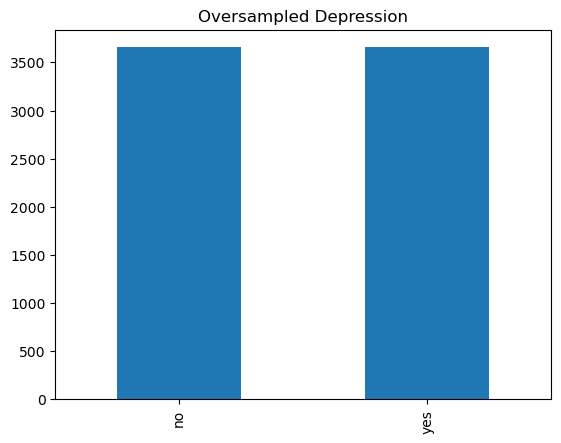

In [25]:
depression_os.value_counts().plot(kind='bar')
plt.title('Oversampled Depression')
plt.show()

# 1.Important Features (Chi-Squares)

In [26]:
import pandas as pd
from sklearn.feature_selection import SelectKBest, chi2

In [27]:
k = 20  # Number of top features to select
selector = SelectKBest(score_func=chi2, k=k)
X_new = selector.fit_transform(X_depression, depression_os)

In [28]:
selected_feature_indices_dep = selector.get_support(indices=True)

In [29]:
selected_feature_names_dep = X.columns[selected_feature_indices_dep]

In [30]:
chi2_scores = selector.scores_[selected_feature_indices_dep]

In [31]:
feature_importance_dep_chi2 = pd.DataFrame({'Depression Features': selected_feature_names_dep, 'Chi2 Score': chi2_scores})
feature_importance_dep_chi2 = feature_importance_dep_chi2.sort_values(by='Chi2 Score', ascending=False)

# Print the feature importance results
feature_importance_dep_chi2.head(20)

,Depression Features,Chi2 Score
3,Year of university,174.426606
13,Parental home,170.648363
19,Drinker (3 levels),146.956522
1,Gender,109.475530
12,Binge drinking,101.953846
9,Urinalysis leukocyturia),88.007407
10,Abnormal urinalysis,87.804878
7,Additional income,83.526316
16,Overweight and obesity,73.380355
6,At least one parent unemployed,71.052863


# 2. Important Features (Random Forest)

In [32]:
from sklearn.ensemble import RandomForestClassifier

In [33]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X_depression, depression_os)

feature_importances_dep_RF = pd.DataFrame({'Depression Features': X_depression.columns, 'Importance': rf.feature_importances_})
feature_importances_dep_RF = feature_importances_dep_RF.sort_values(by='Importance', ascending=False)

# Print the feature importance results
print(feature_importances_dep_RF.head(20))

                 Depression Features  Importance
2                                 PP    0.091849
1                                MAP    0.086533
3                   Heart rate (bpm)    0.084777
0                                BMI    0.080299
7                     Field of study    0.047995
43                     Parental home    0.039588
4                     Age (4 levels)    0.036066
54                Drinker (3 levels)    0.033951
46            Mode of transportation    0.028539
11            Professional objective    0.023201
52       Cigarette smoker (5 levels)    0.021832
26       Physical activity(3 levels)    0.021813
5                             Gender    0.021397
42  Satisfied with living conditions    0.021314
40        Control examination needed    0.018772
23                  Eating junk food    0.018513
53       Cigarette smoker (3 levels)    0.018166
17                             Grant    0.017704
45                      Long commute    0.017430
19          Public h

# 3.  Important Features (ANOVA)

In [34]:
import pandas as pd
from scipy.stats import f_oneway
import numpy as np

# Perform ANOVA for all features
anova_results = {}
for feature in X_depression.columns:
    f_statistic, p_value = f_oneway(*[X_depression[depression_os == group][feature] for group in np.unique(depression_os)])
    anova_results[feature] = {'F-Statistic': f_statistic, 'P-value': p_value}

# Sort the features based on F-statistic in descending order
sorted_features = sorted(anova_results.items(), key=lambda x: x[1]['F-Statistic'], reverse=True)

# Select the top 20 features with non-NaN values
top_20_features = []
for feature, values in sorted_features:
    if not np.isnan(values['F-Statistic']) and not np.isnan(values['P-value']):
        top_20_features.append(feature)
        if len(top_20_features) == 20:
            break

# Create a dataframe to store the top 20 features and their ANOVA results
top_20_df = pd.DataFrame(columns=['Feature', 'F-Statistic', 'P-value'])
for feature in top_20_features:
    f_statistic = anova_results[feature]['F-Statistic']
    p_value = anova_results[feature]['P-value']
    top_20_df = top_20_df.append({'Feature': feature, 'F-Statistic': f_statistic, 'P-value': p_value}, ignore_index=True)

# Print the top 20 features and their corresponding F-statistic and p-value
print(top_20_df)

                             Feature  F-Statistic       P-value
0                      Parental home   371.997831  6.857379e-81
1                 Drinker (3 levels)   344.265539  3.916066e-75
2   Satisfied with living conditions   255.106411  1.792111e-56
3                             Gender   173.686787  3.237134e-39
4          Private health insurance    131.774087  3.041774e-30
5                 Year of university   126.377552  4.399708e-29
6             Professional objective   109.212448  2.199624e-25
7                     Binge drinking   106.240586  9.640629e-25
8                Abnormal urinalysis    90.911603  2.000750e-21
9           Urinalysis leukocyturia)    90.751138  2.167608e-21
10                 Additional income    87.219436  1.264704e-20
11            Overweight and obesity    85.393645  3.149689e-20
12            Having only one parent    79.313371  6.597306e-19
13                    Age (4 levels)    74.513304  7.310023e-18
14    At least one parent unemployed    

# MODELLING With Chi Square Features

In [35]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# Select the top 20 features from the 'feature_importance_Chi2' dataframe
top_20_features = feature_importance_dep_chi2.head(20)['Depression Features'].tolist()

# Create the feature matrix 'X' using the top 20 features
X_dep_chi2 = X_depression[top_20_features]

# Create the target variable 'y'
y_dep_chi2 = depression_os

# Split the data into training and testing sets
X_train_dep_chi2, X_test_dep_chi2, y_train_dep_chi2, y_test_dep_chi2 = train_test_split(X_dep_chi2, y_dep_chi2, test_size=0.3, random_state=42)

In [36]:
from sklearn.preprocessing import LabelEncoder

# Create an instance of LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the training set
y_train_encoded_dep_chi2 = label_encoder.fit_transform(y_train_dep_chi2)

# Transform the test set
y_test_encoded_dep_chi2 = label_encoder.transform(y_test_dep_chi2)


In [37]:
# Initialize a Random Forest classifier
rf_classifier = RandomForestClassifier()

# Fit the classifier on the training data
rf_classifier.fit(X_train_dep_chi2, y_train_encoded_dep_chi2)

RandomForestClassifier()

In [38]:
# Predict on the test data
y_pred_dep_chi2 = rf_classifier.predict(X_test_dep_chi2)

In [39]:
from sklearn.metrics import roc_auc_score, roc_curve, precision_score, accuracy_score, f1_score

# Calculate AUC score
auc_score = roc_auc_score(y_test_encoded_dep_chi2, y_pred_dep_chi2)

# Calculate precision score
precision = precision_score(y_test_encoded_dep_chi2, y_pred_dep_chi2)

# Calculate accuracy
accuracy = accuracy_score(y_test_encoded_dep_chi2, y_pred_dep_chi2)

# Calculate F1 score
f1 = f1_score(y_test_encoded_dep_chi2, y_pred_dep_chi2)

# Print the results
print("AUC score for Depression:", auc_score)
print("Precision for Depression:", precision)
print("Accuracy for Depression:", accuracy)
print("F1 score for Depression:", f1)

AUC score for Depression: 0.7769038359260737
Precision for Depression: 0.7617021276595745
Accuracy for Depression: 0.7771194165907019
F1 score for Depression: 0.7854322071083809


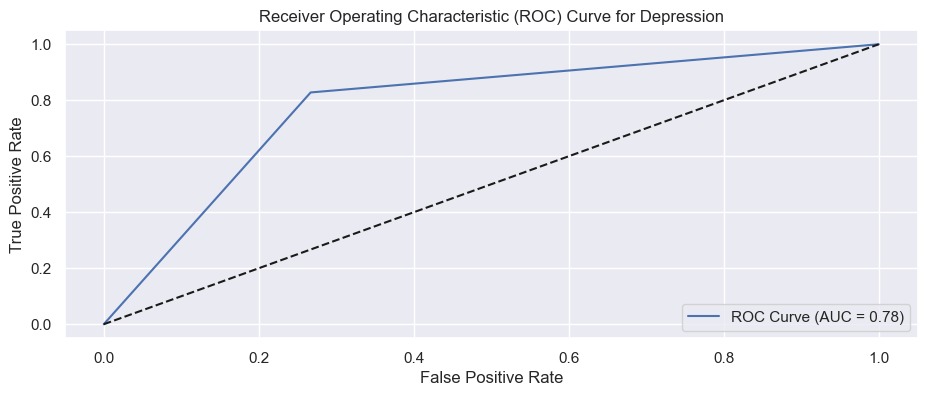

In [42]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# Compute the false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(y_test_encoded_dep_chi2, y_pred_dep_chi2)

# Compute the AUC score
auc_score = roc_auc_score(y_test_encoded_dep_chi2, y_pred_dep_chi2)

# Plot the ROC curve
plt.plot(fpr, tpr, label='ROC Curve (AUC = %0.2f)' % auc_score)
plt.plot([0, 1], [0, 1], 'k--')  # Add the diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Depression')
plt.legend(loc='lower right')
plt.show()

# MODELLING With RF Features

In [40]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# Select the top 20 features from the 'feature_importance_Chi2' dataframe
top_20_features = feature_importances_dep_RF.head(20)['Depression Features'].tolist()

# Create the feature matrix 'X' using the top 20 features
X_dep_RF = X_depression[top_20_features]

# Create the target variable 'y'
y_dep_RF = depression_os

# Split the data into training and testing sets
X_train_dep_RF, X_test_dep_RF, y_train_dep_RF, y_test_dep_RF = train_test_split(X_dep_RF, y_dep_RF, test_size=0.3, random_state=42)

In [41]:
from sklearn.preprocessing import LabelEncoder

# Create an instance of LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the training set
y_train_encoded_dep_RF = label_encoder.fit_transform(y_train_dep_RF)

# Transform the test set
y_test_encoded_dep_RF = label_encoder.transform(y_test_dep_RF)


### 1. Random Forest

In [42]:
# Initialize a Random Forest classifier
rf_classifier = RandomForestClassifier()

# Fit the classifier on the training data
rf_classifier.fit(X_train_dep_RF, y_train_encoded_dep_RF)

RandomForestClassifier()

In [43]:
# Predict on the test data
y_pred_dep_RF = rf_classifier.predict(X_test_dep_RF)

In [44]:
from sklearn.metrics import roc_auc_score, roc_curve, precision_score, accuracy_score, f1_score

# Calculate AUC score
auc_score = roc_auc_score(y_test_encoded_dep_RF, y_pred_dep_RF)

# Calculate precision score
precision = precision_score(y_test_encoded_dep_RF, y_pred_dep_RF)

# Calculate accuracy
accuracy = accuracy_score(y_test_encoded_dep_RF, y_pred_dep_RF)

# Calculate F1 score
f1 = f1_score(y_test_encoded_dep_RF, y_pred_dep_RF)

recall = recall_score(y_test_encoded_dep_RF, y_pred_dep_RF)

# Print the results
print("AUC score for Depression:", auc_score)
print("Precision for Depression:", precision)
print("Accuracy for Depression:", accuracy)
print("F1 score for Depression:", f1)
print("Recall score for Depression:", recall)

AUC score for Depression: 0.882947746310331
Precision for Depression: 0.8946877912395154
Accuracy for Depression: 0.8828623518687329
F1 score for Depression: 0.8819476343592099
Recall score for Depression: 0.8695652173913043


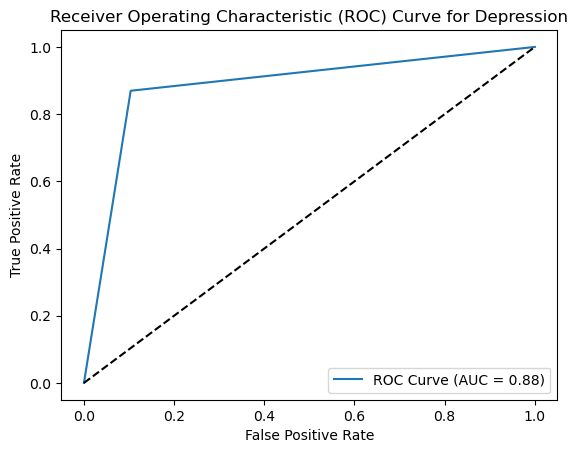

In [45]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# Compute the false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(y_test_encoded_dep_RF, y_pred_dep_RF)

# Compute the AUC score
auc_score = roc_auc_score(y_test_encoded_dep_RF, y_pred_dep_RF)

# Plot the ROC curve
plt.plot(fpr, tpr, label='ROC Curve (AUC = %0.2f)' % auc_score)
plt.plot([0, 1], [0, 1], 'k--')  # Add the diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Depression')
plt.legend(loc='lower right')
plt.show()

### 2. Logistic Regression

In [46]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
X_train_dep_RF, X_test_dep_RF, y_train_dep_RF, y_test_dep_RF = train_test_split(
    X_dep_RF, y_dep_RF, test_size=0.3, random_state=42
)

# Create a Logistic Regression model with L2 normalization
logreg = LogisticRegression(penalty='l2', solver='liblinear', random_state=42)

# Train the model
logreg.fit(X_train_dep_RF, y_train_encoded_dep_RF)

# Make predictions on the test set
y_pred = logreg.predict(X_test_dep_RF)

# Calculate evaluation metrics
f1 = f1_score(y_test_encoded_dep_RF, y_pred)
accuracy = accuracy_score(y_test_encoded_dep_RF, y_pred)
precision = precision_score(y_test_encoded_dep_RF, y_pred)
recall = recall_score(y_test_encoded_dep_RF, y_pred)
auc = roc_auc_score(y_test_encoded_dep_RF, y_pred)

# Print the evaluation metrics
print("Evaluation Metrics:")
print("F1 Score:", f1)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("AUC Score:", auc)


Evaluation Metrics:
F1 Score: 0.6800547695116386
Accuracy: 0.6804922515952598
Precision: 0.6853725850965962
Recall: 0.6748188405797102
AUC Score: 0.6805286863449009


### 3. SVM

In [47]:
from sklearn.svm import SVC
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
X_train_dep_RF, X_test_dep_RF, y_train_dep_RF, y_test_dep_RF = train_test_split(
    X_dep_RF, y_dep_RF, test_size=0.3, random_state=42
)

# Create an SVM model with a polynomial kernel
svm = SVC(kernel='poly', degree=3, random_state=42)

# Train the model
svm.fit(X_train_dep_RF, y_train_encoded_dep_RF)

# Make predictions on the test set
y_pred = svm.predict(X_test_dep_RF)

# Calculate evaluation metrics
f1 = f1_score(y_test_encoded_dep_RF, y_pred)
accuracy = accuracy_score(y_test_encoded_dep_RF, y_pred)
precision = precision_score(y_test_encoded_dep_RF, y_pred)
recall = recall_score(y_test_encoded_dep_RF, y_pred)
auc = roc_auc_score(y_test_encoded_dep_RF, y_pred)

# Print the evaluation metrics
print("Evaluation Metrics:")
print("F1 Score:", f1)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("AUC Score:", auc)


Evaluation Metrics:
F1 Score: 0.7517182130584193
Accuracy: 0.7365542388331814
Precision: 0.7148692810457516
Recall: 0.792572463768116
AUC Score: 0.736194488764792


### 4. KNN

In [48]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
X_train_dep_RF, X_test_dep_RF, y_train_dep_RF, y_test_dep_RF = train_test_split(
    X_dep_RF, y_dep_RF, test_size=0.3, random_state=42
)

# Create the KNN classifier
knn = KNeighborsClassifier(n_neighbors=5)

# Train the model
knn.fit(X_train_dep_RF, y_train_encoded_dep_RF)

# Make predictions on the test set
y_pred = knn.predict(X_test_dep_RF)

# Calculate evaluation metrics
f1 = f1_score(y_test_encoded_dep_RF, y_pred)
accuracy = accuracy_score(y_test_encoded_dep_RF, y_pred)
precision = precision_score(y_test_encoded_dep_RF, y_pred)
recall = recall_score(y_test_encoded_dep_RF, y_pred)
auc = roc_auc_score(y_test_encoded_dep_RF, y_pred)

# Print the evaluation metrics
print("Evaluation Metrics:")
print("F1 Score:", f1)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("AUC Score:", auc)


Evaluation Metrics:
F1 Score: 0.8268066209123941
Accuracy: 0.8044667274384686
Precision: 0.7458120903131829
Recall: 0.927536231884058
AUC Score: 0.8036763728227629


# MODELLING With ANOVA Square Features

In [49]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Select the top 20 features
selected_features = top_20_df['Feature'].tolist()

# Create the feature matrix X and target variable y
X = X_depression[selected_features]
y = depression_os

# Split the data into training and testing sets
X_train_dep_ANOVA, X_test_dep_ANOVA, y_train_dep_ANOVA, y_test_dep_ANOVA = train_test_split(X, y, test_size=0.3, random_state=42)


In [50]:
from sklearn.preprocessing import LabelEncoder

# Create an instance of LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the training set
y_train_encoded_dep_ANOVA = label_encoder.fit_transform(y_train_dep_ANOVA)

# Transform the test set
y_test_encoded_dep_ANOVA = label_encoder.transform(y_test_dep_ANOVA)

In [51]:
# Create an instance of RandomForestClassifier
rf_classifier = RandomForestClassifier(random_state=42)

# Fit the classifier to the training data
rf_classifier.fit(X_train_dep_ANOVA, y_train_encoded_dep_ANOVA)

RandomForestClassifier(random_state=42)

In [52]:
# Predict on the test data
y_pred_dep_ANOVA = rf_classifier.predict(X_test_dep_ANOVA)

In [53]:
from sklearn.metrics import roc_auc_score, roc_curve, precision_score, accuracy_score, f1_score

# Calculate AUC score
auc_score = roc_auc_score(y_test_encoded_dep_ANOVA, y_pred_dep_ANOVA)

# Calculate precision score
precision = precision_score(y_test_encoded_dep_ANOVA, y_pred_dep_ANOVA)

# Calculate accuracy
accuracy = accuracy_score(y_test_encoded_dep_ANOVA, y_pred_dep_ANOVA)

# Calculate F1 score
f1 = f1_score(y_test_encoded_dep_ANOVA, y_pred_dep_ANOVA)

# Print the results
print("AUC score for Anxiety with ANOVA:", auc_score)
print("Precision for Anxiety with ANOVA:", precision)
print("Accuracy for Anxiety with ANOVA:", accuracy)
print("F1 score for Anxiety with ANOVA:", f1)

AUC score for Anxiety with ANOVA: 0.7562209147719718
Precision for Anxiety with ANOVA: 0.7309562398703403
Accuracy for Anxiety with ANOVA: 0.7566089334548769
F1 score for Anxiety with ANOVA: 0.7715996578272026


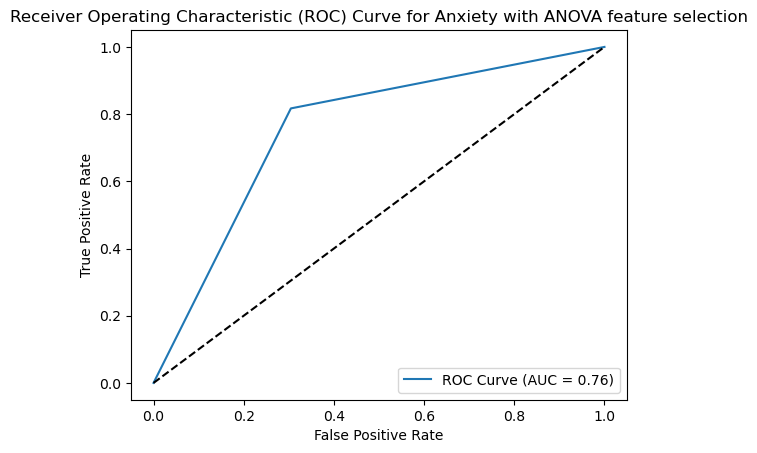

In [54]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# Compute the false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(y_test_encoded_dep_ANOVA, y_pred_dep_ANOVA)

# Compute the AUC score
auc_score = roc_auc_score(y_test_encoded_dep_ANOVA, y_pred_dep_ANOVA)

# Plot the ROC curve
plt.plot(fpr, tpr, label='ROC Curve (AUC = %0.2f)' % auc_score)
plt.plot([0, 1], [0, 1], 'k--')  # Add the diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Anxiety with ANOVA feature selection')
plt.legend(loc='lower right')
plt.show()